In [12]:
using LinearAlgebra
using SparseArrays

using Plots
using LaTeXStrings

using gmsh

# Define Geometry

In [13]:
xmin = 0;
xmax = 1;

a = 0.35; b = 0.45;
c = 0.55; d = 0.65;

lc1 = 1e-1;
lc2 = 1e-2;

In [14]:
gmsh.initialize()

In [15]:
gmsh.option.setNumber("General.Terminal", 1)     # Enable printing information to terminal
gmsh.model.add("coil")                           # Create a new model

# Nodes
gmsh.model.geo.addPoint(xmin, 0, 0, lc1, 1)
gmsh.model.geo.addPoint(a, 0, 0, lc2, 2)
gmsh.model.geo.addPoint(b, 0, 0, lc2, 3)
gmsh.model.geo.addPoint(c, 0, 0, lc2, 4)
gmsh.model.geo.addPoint(d, 0, 0, lc2, 5)
gmsh.model.geo.addPoint(xmax, 0, 0, lc1, 6)

# Elements
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 5, 4)
gmsh.model.geo.addLine(5, 6, 5)

# Physical properties
gmsh.model.addPhysicalGroup(1, [1, 3, 5], 1)
gmsh.model.addPhysicalGroup(1, [2, 4], 2)

gmsh.model.addPhysicalGroup(0, [1,6], 1)
gmsh.model.setPhysicalName(0, 1, "D") # Dirichlet boundary condition

# Generate 1D mesh
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(1)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00939226s, CPU 0s)
Info    : 49 nodes 54 elements


In [16]:
# Retrieve nodes from gmsh and sort in order of x-coords
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
xnode = node_coord[1:3:end];
p = sortperm(xnode);
x = xnode[p];
nids = node_ids[p];

# Auxiliary functions

In [17]:
function get_idx(node_id, nids)
    return findall(x -> x == node_id, nids)[1];
end

function bnd_dirichlet(idx, a, A, f)
    A[idx,:]   = zeros(length(f));
    A[idx,idx] = 1;
    f[idx] = a;
    
    return A, f;
end

bnd_dirichlet (generic function with 1 method)

# Linear Elements

In [18]:
#..Set the source function 
J = 1e6;
fsource(x) = J * (x > a) * (x < b) - J * (x > c) * (x < d); 

mu0 = 4e-7 * pi;
mu_r = 1000;
mu(x) = mu0 + (mu_r - 1) * mu0 * (x > b) * (x < c);;
cfun(x) = 1 / mu(x);

In [19]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1] for i in 1:length(x)-1); 

#..Initialize global matrix and right-hand side value 
A = zeros(length(x), length(x)); 
f = zeros(length(x)); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 
    xl, xr = points[i,:][1]
    floc = (xr-xl) / 2 * [fsource(xl); fsource(xr)];
    Aloc = cfun((xr + xl)/2) / (xr-xl) * [1 -1; -1 1]; 

    f[edges[i]] += floc;
    A[edges[i], edges[i]] += Aloc;
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A, f = bnd_dirichlet(get_idx(1, nids), 0, A, f);    # Boundary at x = 0
A, f = bnd_dirichlet(get_idx(6, nids), 0, A, f);    # Boundary at x = 1

#..solve the linear system
u  = A \ f;

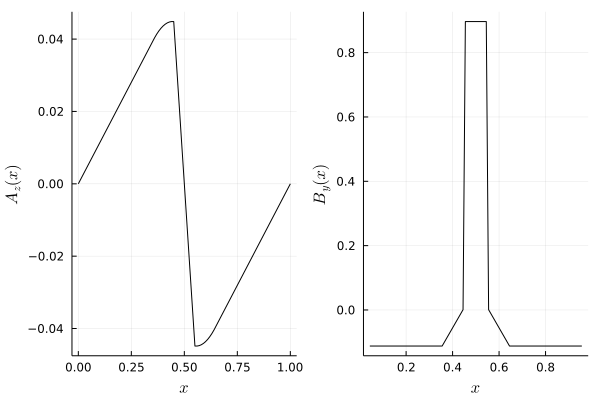

In [20]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);

# Plot
p1 = plot(x, u, xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(xmid, -ux, xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false);

plot(p1, p2)

In [21]:
[minimum(u), maximum(u)]

2-element Vector{Float64}:
 -0.04484438255553918
  0.0448443825553791

In [22]:
[minimum(ux), maximum(ux)]

2-element Vector{Float64}:
 -0.8967083094472946
  0.11220062721978409

# Quadratic Elements

In [23]:
Na = 2 * length(x) - 1;
points = collect( [x[i], 0.5*(x[i] + x[i+1]), x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1, i+2] for i in 1:2:Na-1); 

X = collect([points[i][1], points[i][2]] for i in 1:length(points))
X = reduce(vcat, X);
X = vcat(X, x[end]);

In [24]:
#..Initialize global matrix and right-hand side value 
A = zeros(Na, Na); 
f = zeros(Na); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 
    xl, xm, xr = points[i,:][1];
    
    h = xr - xl;
    floc = h / 6 * [fsource(xl); 4 * fsource(xm); fsource(xr)];
    Aloc = cfun(xm) * [7 -8 1; -8 16 -8; 1 -8 7] / (3 * h); 

    f[edges[i]] += floc;
    A[edges[i], edges[i]] += Aloc;
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,:]   = zeros(Na);  A[1,1]     = 1;      f[1]   = 0;
A[end,:] = zeros(Na);  A[end,end] = 1;      f[end]   = 0;

#..solve the linear system
u  = A \ f;

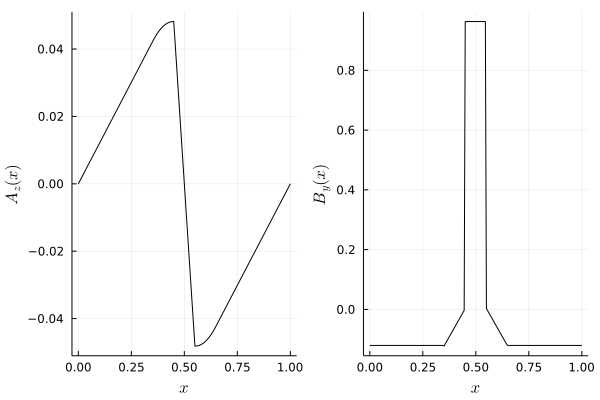

In [25]:
# Post-processing
ux = zeros(Na);

Emat = 2 * [2, -4, 2] * [0 0.5 1] .+ [-3, 4, -1];
for i=1:length(edges) 
    xl, xm, xr = points[i,:][1];
    ul, um, ur = u[edges[i]];
    
    dux = [ul um ur] * Emat / (xr - xl);
    
    ux[edges[i]] = dux';
end

# Plot
p1 = plot(X, u, xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(X, -ux, xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false);

plot(p1, p2)

In [26]:
[minimum(u), maximum(u)]

2-element Vector{Float64}:
 -0.04815655735930061
  0.04815655735958137

In [28]:
[minimum(ux), maximum(ux)]

2-element Vector{Float64}:
 -0.9631311471888248
  0.12260617989403005